In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'MEDV']
    y = dataframe['MEDV']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

X_train, X_test, y_train, y_test = split_df(df, seed=42, percentage=0.5)

# Exercise # 2

This problem involves the `OJ` data set.

0. Load and preview the dataset, to understand what is it about.
1. Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.
2. Fit a tree to the training data, with Purchase as the response and the other variables as predictors. 
3. Create a plot of the tree, and interpret the results.
4. Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test accuracy?
5. Apply CV to determine the optimal tree size.
6. Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.
7. Which tree size corresponds to the lowest cross-validated classification error rate?
8. Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation.
10. Compare the accuracy between the pruned and unpruned trees. Which is higher?

#### 0. Load and preview the dataset, to understand what is it about.

In [30]:
import io
import requests

OJ=pd.read_csv("https://raw.githubusercontent.com/jcrouser/islr-python/master/data/OJ.csv", index_col=0)
OJ.head(5)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


#### 1. Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.


In [31]:
OJ.Store7.replace(['No','Yes'],[0,1],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(OJ.loc[:, OJ.columns != 'Purchase'], OJ['Purchase'], train_size=800, random_state=42)

#### 2. Fit a tree to the training data, with Purchase as the response and the other variables as predictors.

In [32]:
from sklearn.tree import DecisionTreeClassifier

oj_tree = DecisionTreeClassifier(random_state=42)
oj_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### 3. Create a plot of the tree, and interpret the results.


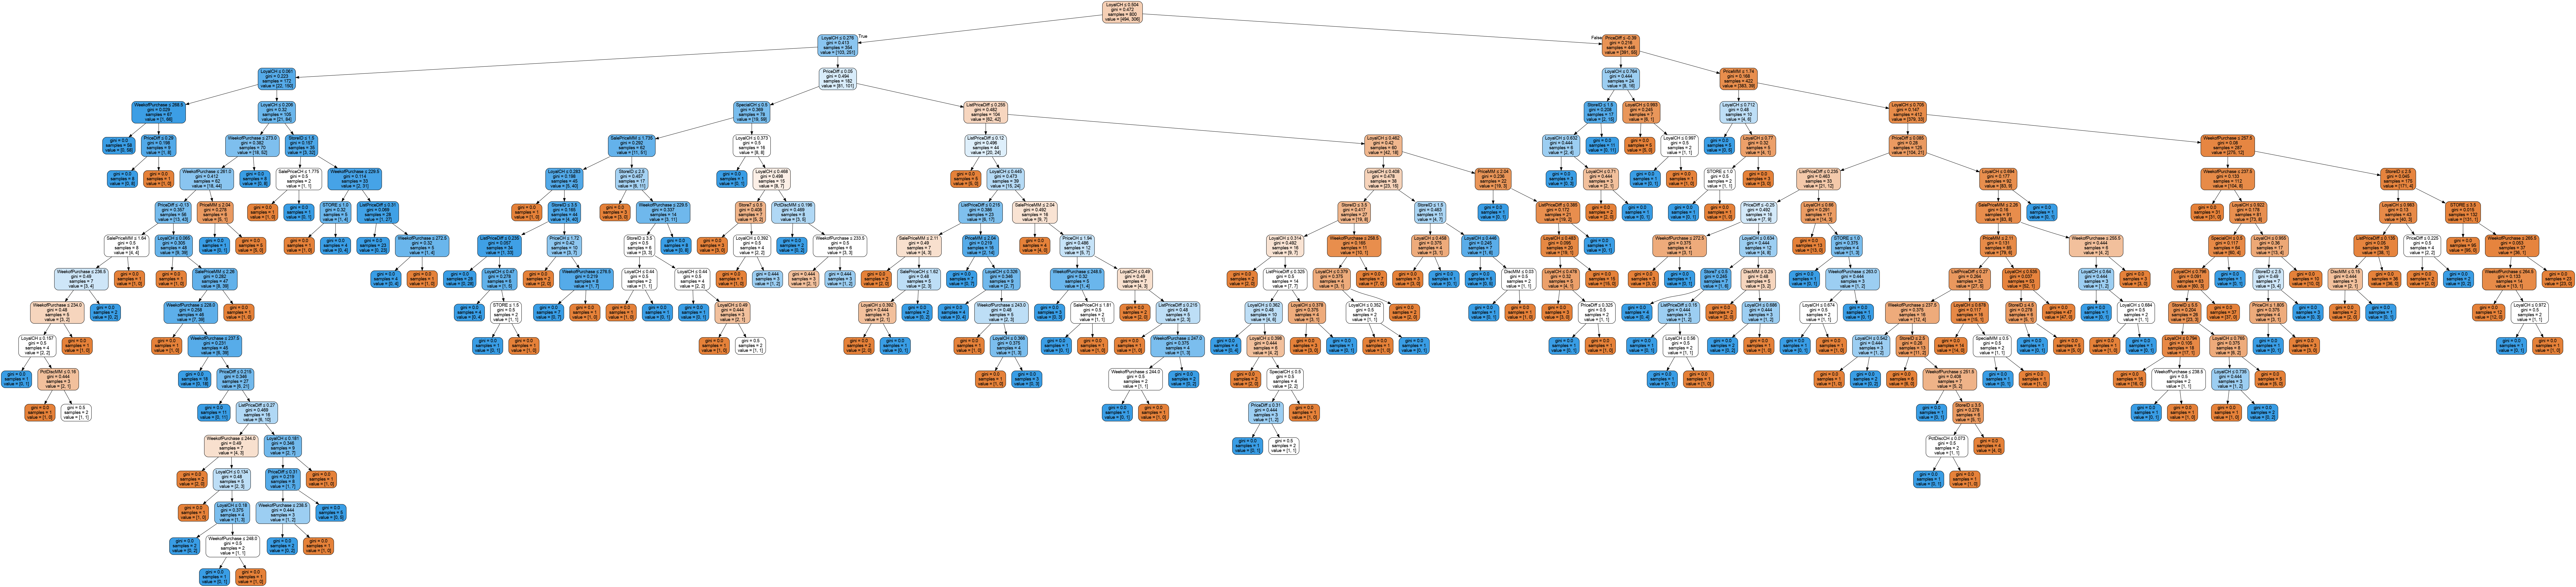

In [33]:
dot_data = StringIO()
export_graphviz(oj_tree, out_file=dot_data, feature_names=X_train.columns,
                filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

According to the tree, `LoyalCH` and `PriceDiff` seem to be the most important features. Does it make sense?

#### 4. Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test accuracy?


Accuracy = 0.7222


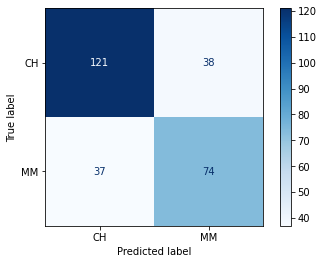

In [45]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

predictions = oj_tree.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,oj_tree.predict(X_test))))
plot_confusion_matrix(oj_tree, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

#### 5. Apply CV to determine the optimal tree size.

In [35]:
param_grid = {'max_depth': range(1,16)}

oj_tree_pruned_cv = GridSearchCV(oj_tree, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

oj_tree_pruned_cv.fit(X_train,y_train)
print("Best parameters set found on development set:")
print()
print(oj_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = oj_tree_pruned_cv.cv_results_['mean_test_score']
stds = oj_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, oj_tree_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters set found on development set:

{'max_depth': 4}

Grid scores on development set:

Accuracy = 0.796 (+/0.037) for {'max_depth': 1}
Accuracy = 0.801 (+/0.040) for {'max_depth': 2}
Accuracy = 0.825 (+/0.027) for {'max_depth': 3}
Accuracy = 0.834 (+/0.042) for {'max_depth': 4}
Accuracy = 0.830 (+/0.058) for {'max_depth': 5}
Accuracy = 0.818 (+/0.038) for {'max_depth': 6}
Accuracy = 0.806 (+/0.056) for {'max_depth': 7}
Accuracy = 0.799 (+/0.056) for {'max_depth': 8}
Accuracy = 0.785 (+/0.043) for {'max_depth': 9}
Accuracy = 0.790 (+/0.050) for {'max_depth': 10}
Accuracy = 0.790 (+/0.064) for {'max_depth': 11}
Accuracy = 0.792 (+/0.059) for {'max_depth': 12}
Accuracy = 0.785 (+/0.051) for {'max_depth': 13}
Accuracy = 0.787 (+/0.055) for {'max_depth': 14}
Accuracy = 0.790 (+/0.054) for {'max_depth': 15}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.0s finished


#### 6. Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

Text(0, 0.5, 'Accuracy')

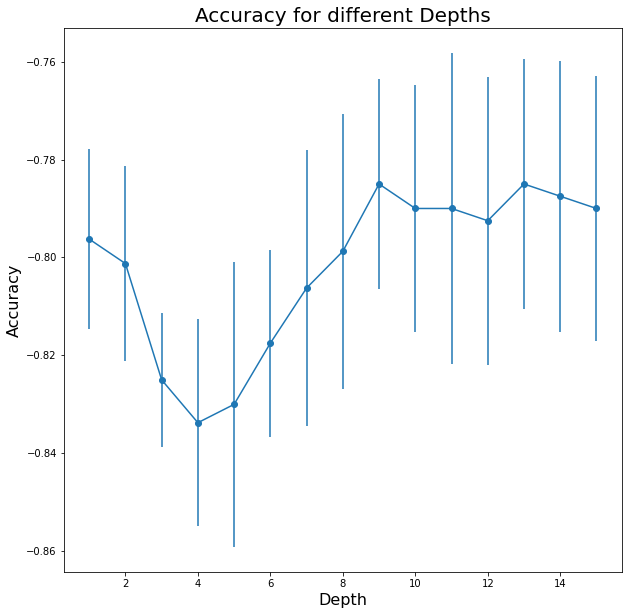

In [36]:
plt.figure(figsize=(10,10))
plt.errorbar(range(1,16,1), [-m for m in means], yerr=stds, fmt='-o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

#### 7. Which tree size corresponds to the lowest cross-validated classification error rate?


According to the previous plot, the best CV error correspond to a tree with depth 4. 

#### 8. Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation.

In [37]:
oj_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=6)
oj_tree_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

#### 10. Compare the accuracy between the pruned and unpruned trees. Which is higher?

Accuracy = 0.7667


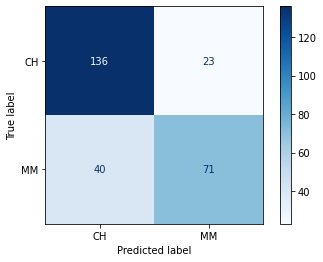

In [46]:
predictions = oj_tree_pruned.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test, predictions)))
plot_confusion_matrix(oj_tree_pruned, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

By pruning the tree we have improved the test accuracy of the model from .72 to .77

# Exercise 3

Try to solve the **Exercise #2** with Boosting trees by playing around with the `xgboost`(https://xgboost.readthedocs.io/en/latest/python/python_intro.html) library. 

In [39]:
import xgboost

This code trains a XGBoost tree with default parameters

Accuracy = 0.7444


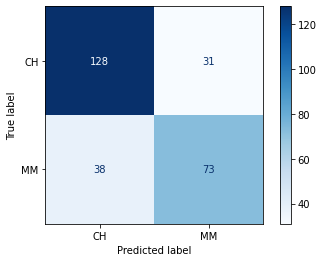

In [40]:
xgb_tree = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_tree.fit(X_train, y_train)
predictions = xgb_tree.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,xgb_tree.predict(X_test))))
plot_confusion_matrix(xgb_tree, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

Result are not very much impressive. We have a similar performance than with the single Decision Tree. XGboost is very sensitive to the hyperparameter configuration, let's see if we can further improve the performance by optimizing these hyperparamters.

In [41]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_pa...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff828599be0>,
       

With the same code than before we can plot the results of each combination of hyperparameters.

In [42]:
print("Best parameters set found on development set:")
print()
print(search.best_params_)
print()
print("Grid scores on development set:")
print()
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'colsample_bytree': 0.7779849588562787, 'gamma': 0.22662042341441552, 'learning_rate': 0.03969478533289514, 'max_depth': 2, 'n_estimators': 132, 'subsample': 0.7644826883488745}

Grid scores on development set:

MSE = 0.814 (+/0.061) for {'colsample_bytree': 0.8123620356542087, 'gamma': 0.4753571532049581, 'learning_rate': 0.24959818254342153, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.6624074561769746}
MSE = 0.789 (+/0.048) for {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}
MSE = 0.809 (+/0.042) for {'colsample_bytree': 0.7061753482887407, 'gamma': 0.48495492608099716, 'learning_rate': 0.2797327922401265, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.6727299868828402}
MSE = 0.793 (+/0.043) for {'colsample_bytree': 0.7550213529560301, 'gamma': 0.15212112147976886, 'learning_rate': 0.18742692948

As you can see, the possible number of combinations is very large. The model with the best combination of hyperparamters is stored in the object `best_estimator_` that you can then use to predict

Accuracy = 0.8148


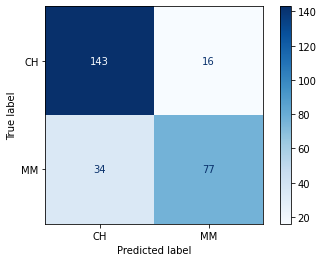

In [43]:
predictions = search.best_estimator_.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,search.best_estimator_.predict(X_test))))
plot_confusion_matrix(search.best_estimator_, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

We have further improved the model performance up to 81.5 of accuracy by optimizing the hyperparameters.

Finally you can take a look to the feature importance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

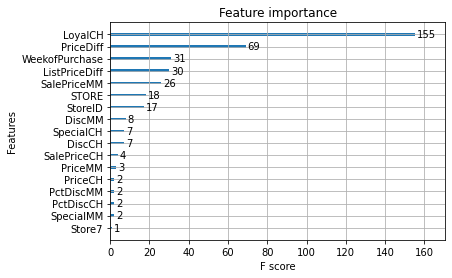

In [44]:
xgboost.plot_importance(search.best_estimator_)